In [ ]:
import torch
from torch_geometric.utils import to_networkx, from_networkx
from sklearn import metrics
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

/users/Min/miniconda/envs/hy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
edge = torch.load('/dev/shm/twi20/processed_data/edge_index.pt')
edge.shape

torch.Size([2, 117110])

In [3]:
label = torch.load('/dev/shm/twi20/processed_data/label.pt')
label.shape

torch.Size([11826])

In [4]:
train_idx = torch.load('/dev/shm/twi20/processed_data/train_idx.pt')
val_idx = torch.load('/dev/shm/twi20/processed_data/val_idx.pt')
test_idx = torch.load('/dev/shm/twi20/processed_data/test_idx.pt')
train_idx.shape,val_idx.shape,test_idx.shape


(torch.Size([8278]), torch.Size([2365]), torch.Size([1183]))

In [5]:
path = '/dev/shm/twi20/processed_data/'
num,cat =  torch.load(path+'num_properties_tensor.pt'), torch.load(path+'cat_properties_tensor.pt')
num.shape,cat.shape

(torch.Size([229580, 5]), torch.Size([229580, 3]))

In [7]:
label[train_idx],label[train_idx].shape

(tensor([0, 1, 0,  ..., 1, 1, 1]), torch.Size([8278]))

In [15]:
torch.sum(label[train_idx]).item()/label[train_idx].shape[0],torch.sum(label[val_idx]).item()/label[val_idx].shape[0],torch.sum(label[test_idx]).item()/label[test_idx].shape[0]

(0.5612466779415318, 0.5509513742071882, 0.5409974640743872)

In [16]:
train_idx

tensor([   0,    1,    2,  ..., 8275, 8276, 8277])

In [18]:
node_idx = torch.cat([train_idx,val_idx,test_idx],dim=0)
node_idx.shape

torch.Size([11826])

In [19]:
x = torch.cat([num,cat],dim=1)
x.shape

torch.Size([229580, 8])

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_neighbor_similarity(edge, x, node_idx, label):
    # 构建一个邻接表
    num_nodes = x.size(0)
    edge_index = edge  # shape [2, num_edges]

    # 创建邻接表（有标签节点之间的连接）
    adj_dict = defaultdict(list)
    labeled_set = set(node_idx.tolist())

    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]

    for src, dst in zip(src_nodes.tolist(), dst_nodes.tolist()):
        if src in labeled_set and dst in labeled_set:
            adj_dict[src].append(dst)

    # 准备相似度列表
    human_human_sim = []
    human_bot_sim = []
    bot_bot_sim = []
    bot_human_sim = []

    for node in node_idx.tolist():
        node_label = label[node].item()
        node_feat = x[node]

        neighbors = adj_dict[node]
        for nei in neighbors:
            nei_label = label[nei].item()
            nei_feat = x[nei]

            sim = F.cosine_similarity(node_feat.unsqueeze(0), nei_feat.unsqueeze(0)).item()

            if node_label == 0:  # human node
                if nei_label == 0:
                    human_human_sim.append(sim)
                else:
                    human_bot_sim.append(sim)
            else:  # bot node
                if nei_label == 1:
                    bot_bot_sim.append(sim)
                else:
                    bot_human_sim.append(sim)

    return human_human_sim, human_bot_sim, bot_bot_sim, bot_human_sim


# 绘图
def plot_bar_chart(hh, hb, bb, bh):
    categories = ['Human-Human', 'Human-Bot', 'Bot-Bot', 'Bot-Human']
    means = [
        sum(hh) / len(hh) if hh else 0,
        sum(hb) / len(hb) if hb else 0,
        sum(bb) / len(bb) if bb else 0,
        sum(bh) / len(bh) if bh else 0,
    ]

    plt.figure(figsize=(8, 5))
    plt.bar(categories, means, color=['blue', 'orange', 'green', 'red'])
    plt.ylabel('Average Cosine Similarity')
    plt.title('Cosine Similarity between Node and Its Labeled Neighbors')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



In [22]:

# 调用函数
hh_sim, hb_sim, bb_sim, bh_sim = compute_neighbor_similarity(edge, x, node_idx, label)
hh_sim, hb_sim, bb_sim, bh_sim

([0.7583879828453064,
  0.9894765019416809,
  0.997779130935669,
  0.8745524287223816,
  0.658167839050293,
  0.08992528915405273,
  0.3620915412902832,
  0.3720027208328247,
  0.5798646807670593,
  0.4036693572998047,
  0.5166795253753662,
  -0.15810902416706085,
  0.8792034387588501,
  -0.009364597499370575,
  -0.09780934453010559,
  0.8551051616668701,
  0.40205293893814087,
  0.020052224397659302,
  0.552253246307373,
  0.16215386986732483,
  0.9921854734420776,
  0.8712051510810852,
  0.5597659349441528,
  0.61224365234375,
  0.9120445847511292,
  0.36616188287734985,
  0.4601176083087921,
  0.017583999782800674,
  0.08393226563930511,
  -0.12413401156663895,
  -0.13001681864261627,
  0.1694321185350418,
  -0.09643159806728363,
  -0.2721996307373047,
  -0.4040663540363312,
  -0.7884729504585266,
  -0.12737494707107544,
  -0.6927339434623718,
  -0.14036589860916138,
  -0.9172319173812866,
  -0.2876720726490021,
  -0.13271227478981018,
  -0.22532954812049866,
  0.1954280436038971,
 

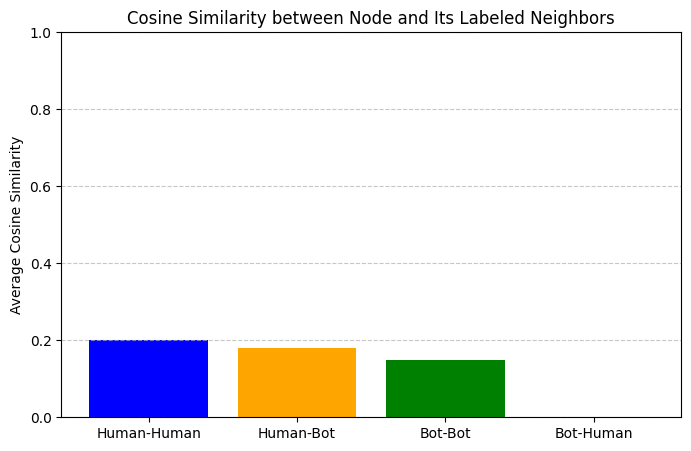

In [23]:

# 画图
plot_bar_chart(hh_sim, hb_sim, bb_sim, bh_sim)

Mean Similarity:
Human-Human: 0.2019
Human-Bot  : 0.1800
Bot-Bot    : 0.1480
Bot-Human  : -0.0624


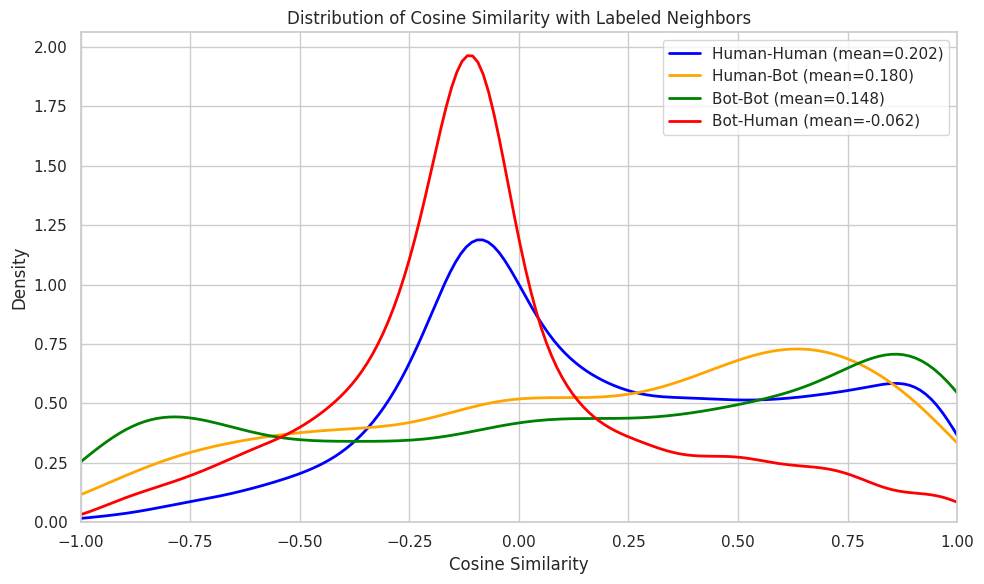

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_distribution(hh, hb, bb, bh):
    # 计算均值
    mean_hh = np.mean(hh) if hh else 0
    mean_hb = np.mean(hb) if hb else 0
    mean_bb = np.mean(bb) if bb else 0
    mean_bh = np.mean(bh) if bh else 0

    print(f"Mean Similarity:")
    print(f"Human-Human: {mean_hh:.4f}")
    print(f"Human-Bot  : {mean_hb:.4f}")
    print(f"Bot-Bot    : {mean_bb:.4f}")
    print(f"Bot-Human  : {mean_bh:.4f}")

    # 设置 seaborn 样式
    sns.set(style="whitegrid")

    # 创建一个图
    plt.figure(figsize=(10, 6))

    # 画分布图
    sns.kdeplot(hh, label=f'Human-Human (mean={mean_hh:.3f})', linewidth=2, color='blue')
    sns.kdeplot(hb, label=f'Human-Bot (mean={mean_hb:.3f})', linewidth=2, color='orange')
    sns.kdeplot(bb, label=f'Bot-Bot (mean={mean_bb:.3f})', linewidth=2, color='green')
    sns.kdeplot(bh, label=f'Bot-Human (mean={mean_bh:.3f})', linewidth=2, color='red')

    plt.title('Distribution of Cosine Similarity with Labeled Neighbors')
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.legend()
    plt.xlim(-1, 1)  # Cosine similarity is in [-1, 1]
    plt.tight_layout()
    plt.show()

# 调用
plot_distribution(hh_sim, hb_sim, bb_sim, bh_sim)


In [26]:
def plot_cdf(hh, hb, bb, bh):
    plt.figure(figsize=(10, 6))

    def cdf(data):
        data = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return data, y

    x_hh, y_hh = cdf(hh)
    x_hb, y_hb = cdf(hb)
    x_bb, y_bb = cdf(bb)
    x_bh, y_bh = cdf(bh)

    plt.plot(x_hh, y_hh, label=f'Human-Human', color='blue')
    plt.plot(x_hb, y_hb, label=f'Human-Bot', color='orange')
    plt.plot(x_bb, y_bb, label=f'Bot-Bot', color='green')
    plt.plot(x_bh, y_bh, label=f'Bot-Human', color='red')

    plt.title("CDF of Cosine Similarity")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()


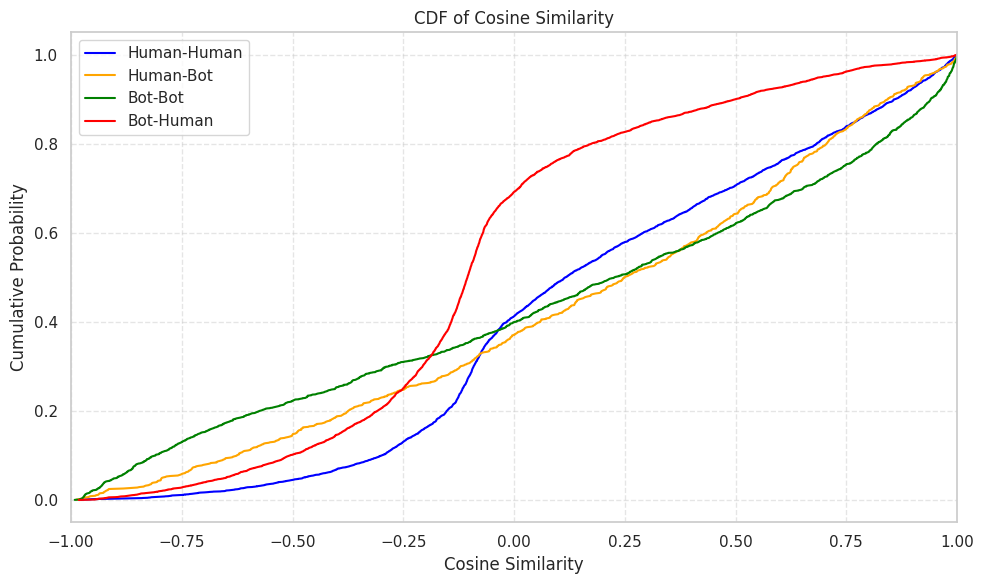

In [27]:
plot_cdf(hh_sim, hb_sim, bb_sim, bh_sim)

In [28]:
def compute_neighbor_similarity(edge, x, node_idx, label):
    # 构建一个邻接表
    num_nodes = x.size(0)
    edge_index = edge  # shape [2, num_edges]

    # 创建邻接表（有标签节点之间的连接）
    adj_dict = defaultdict(list)
    labeled_set = set(node_idx.tolist())

    src_nodes = edge_index[0]
    dst_nodes = edge_index[1]

    for src, dst in zip(src_nodes.tolist(), dst_nodes.tolist()):
        if src in labeled_set and dst in labeled_set:
            adj_dict[src].append(dst)

    # 准备相似度列表
    human_nei_sim = []
    bot_nei_sim = []
    

    for node in node_idx.tolist():
        node_label = label[node].item()
        node_feat = x[node]

        neighbors = adj_dict[node]
        for nei in neighbors:
            # nei_label = label[nei].item()
            nei_feat = x[nei]

            sim = F.cosine_similarity(node_feat.unsqueeze(0), nei_feat.unsqueeze(0)).item()

            if node_label == 0:  # human node
                human_nei_sim.append(sim)
                
            else:  # bot node
                bot_nei_sim.append(sim)

    return human_nei_sim, bot_nei_sim

In [29]:
human_nei_sim, bot_nei_sim = compute_neighbor_similarity(edge, x, node_idx, label)
np.mean(human_nei_sim), np.mean(bot_nei_sim)

(0.1978562918907327, -0.0014289330360460777)

In [30]:
def plot_cdf(h_sim, b_sim):
    plt.figure(figsize=(10, 6))

    def cdf(data):
        data = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return data, y

    x_hh, y_hh = cdf(h_sim)
    x_bb, y_bb = cdf(b_sim)

    plt.plot(x_hh, y_hh, label=f'Human', color='blue')
    # plt.plot(x_hb, y_hb, label=f'Human-Bot', color='orange')
    plt.plot(x_bb, y_bb, label=f'Bot', color='green')
    # plt.plot(x_bh, y_bh, label=f'Bot-Human', color='red')

    plt.title("CDF of Cosine Similarity")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()

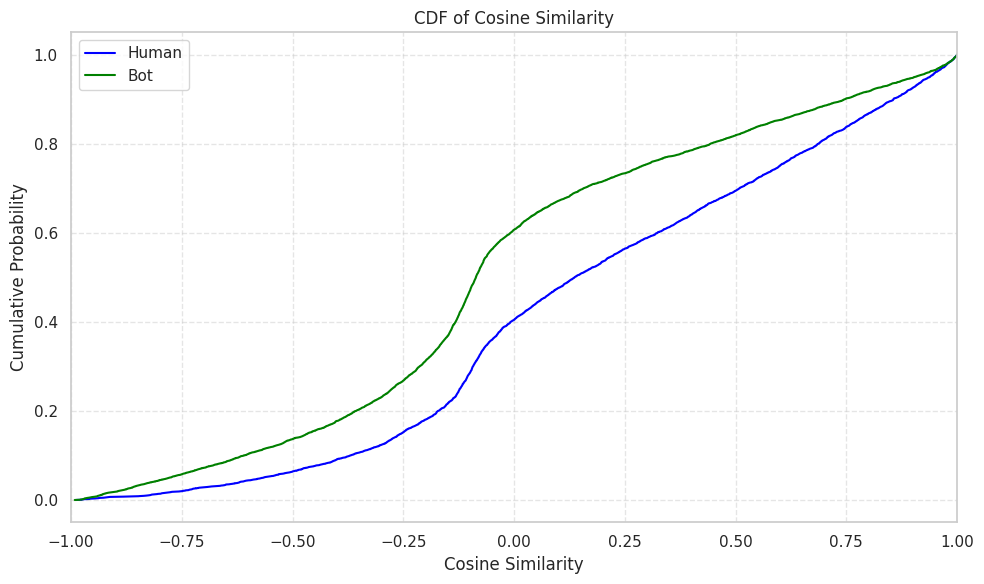

In [31]:
plot_cdf(human_nei_sim, bot_nei_sim)

In [44]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import shortest_path
from tqdm import tqdm

def compute_bot_similarity_by_distance(edge, x, node_idx, label):
    num_nodes = x.size(0)
    edge_np = edge.cpu().numpy()
    
    # 构建邻接矩阵（无向图）
    A = coo_matrix((np.ones(edge_np.shape[1]), (edge_np[0], edge_np[1])), shape=(num_nodes, num_nodes))
    A = A + A.T  # 无向图
    A = A.tocsr()

    # 仅考虑 labeled 节点（更小规模）
    labeled_nodes = node_idx.cpu().numpy()
    label_np = label.cpu().numpy()

    # 子图：只考虑有标签节点
    node_map = {old: new for new, old in enumerate(labeled_nodes)}
    x_labeled = x[labeled_nodes]
    label_labeled = label_np[labeled_nodes]

    # 重新映射边
    mask_src = np.isin(edge_np[0], labeled_nodes)
    mask_dst = np.isin(edge_np[1], labeled_nodes)
    mask = mask_src & mask_dst
    edge_sub = edge_np[:, mask]
    edge_sub = np.vectorize(node_map.get)(edge_sub)

    # 构建子图邻接矩阵
    sub_A = coo_matrix((np.ones(edge_sub.shape[1]), (edge_sub[0], edge_sub[1])), shape=(len(labeled_nodes), len(labeled_nodes)))
    sub_A = sub_A + sub_A.T
    sub_A = sub_A.tocsr()

    # 最短路径距离矩阵
    dist_matrix = shortest_path(sub_A, directed=False, unweighted=True)

    # 相似度存储
    bb_short, bh_short, bb_long, bh_long = [], [], [], []

    for i in tqdm(range(len(labeled_nodes)), desc="Computing similarities"):
        if label_labeled[i] != 1:  # 只分析 bot 节点
            continue
        for j in range(len(labeled_nodes)):
            if i == j or np.isinf(dist_matrix[i, j]):
                continue
            sim = F.cosine_similarity(x_labeled[i].unsqueeze(0), x_labeled[j].unsqueeze(0)).item()
            dist = dist_matrix[i, j]
            if dist <= 2:
                if label_labeled[j] == 1:
                    bb_short.append(sim)
                else:
                    bh_short.append(sim)
            elif dist >= 3:
                if label_labeled[j] == 1:
                    bb_long.append(sim)
                else:
                    bh_long.append(sim)

    return {
        "bb_short": bb_short,
        "bh_short": bh_short,
        "bb_long": bb_long,
        "bh_long": bh_long
    }


In [45]:
results = compute_bot_similarity_by_distance(edge, x, node_idx, label)


Computing similarities: 100%|██████████| 11826/11826 [45:37<00:00,  4.32it/s] 


In [46]:
def plot_cdf_similarity(results):
    import matplotlib.pyplot as plt
    def plot_cdf(data, label, color):
        data = np.sort(np.array(data))
        yvals = np.arange(len(data)) / float(len(data))
        plt.plot(data, yvals, label=label, linewidth=2, color=color)

    plt.figure(figsize=(8, 6))
    plot_cdf(results["bb_short"], "Bot-Bot ≤2-hop", "#1f77b4")
    plot_cdf(results["bb_long"], "Bot-Bot ≥3-hop", "#ff7f0e")
    plot_cdf(results["bh_short"], "Bot-Human ≤2-hop", "#2ca02c")
    plot_cdf(results["bh_long"], "Bot-Human ≥3-hop", "#d62728")

    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.ylabel("Cumulative Probability", fontsize=12)
    plt.title("CDF of Bot Similarities (Short vs Long Range)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_626705/3294014469.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/users/Min/miniconda/envs/hy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


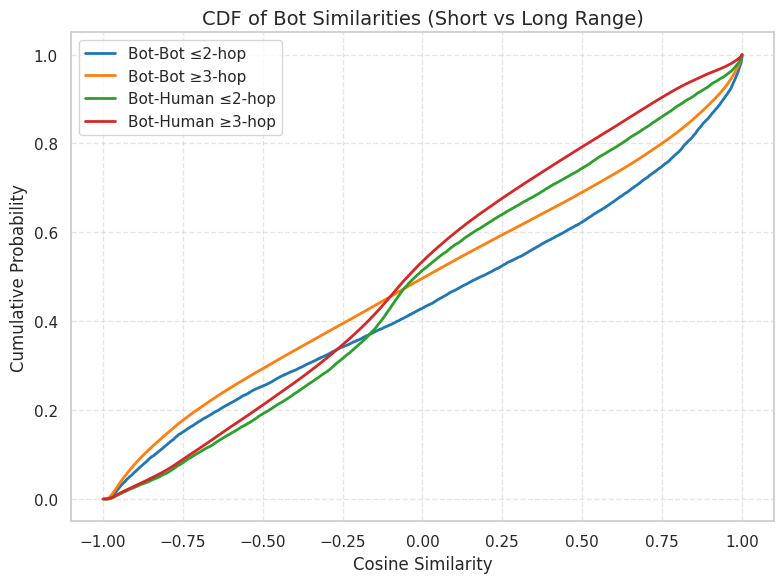

In [47]:
plot_cdf_similarity(results)